# Multivariate Regression

In [14]:

from datetime import datetime, timedelta, date
from calendar import monthrange
from typing import List, Tuple
from ast import Dict
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import cdsapi
import utils
import whittaker_smooth as ws
import numpy as np
from scipy import stats
import statsmodels.api as sm

## API parameters for temperature and precipitation extraction

In [104]:
def images_time_info(
    img_keys: List[str],
    initial_date,
) -> Tuple [List, List, List]:
    """
    Changes the images dates to the natural number day after query begins.
    Returns list of natural number days, list of dates, list of hours.
    Initial date must be in datetime.date(Y,m,d) format.
    """
    # Lists of dates, hours and timestamps.
    dates_list = []
    hours_list = []
    timestamps_list = []
    # Iterate over the key list.
    for image_details in img_keys:
        # Parse the date from the key.
        date = pd.to_datetime(image_details[0:15])
        day_format = date.strftime('%Y-%m-%d')
        dates_list.append(day_format)
        timestamps_list.append(date)
        # Hours from images retrieved
        hour_of_day = date.strftime('%H:%M')
        hours_list.append(hour_of_day)

    # Sorts.
    dates_list.sort()


    # List of numbers.
    initial_date = datetime(timestamps_list[0].year, initial_date.month, initial_date.day)
    # Calculate the differences between the initial and the nexts days.
    day_numbers = [datetime.strptime(day, '%Y-%m-%d') - initial_date for day in dates_list]
    # Get the difference in days.
    day_numbers = [day // timedelta(days=1) for day in day_numbers]

    return day_numbers, sorted(timestamps_list), hours_list


IMGS_PATH = ('D:\VSCode\Repositorios\Plant-Growth-Cycle-based-on-geospatial-data-1\DataExtraction\DataBase\Kansas-2022')
band_labels = ["B4", "B3", "B2", "B8"]
images = utils.load_landsat_image(IMGS_PATH, band_labels)
img_keys = list(images.keys())
initial_date=date(2019, 4, 1)
days, timestamps_list, hours_list = images_time_info(img_keys, initial_date)

In [105]:

start_dt = date(2019, 4, 1)
end_dt   = date(2021,12, 1)

#Function that returns a the days between two dates (the inicial date and the las date)
def date_range(date_min, date_max):
    #GWe generate a for to iterate through the correct range of dates.
    for difference_between_dates in range(int ((date_max - date_min).days)+1):
        #Use yield to return the dates given by the difference starting at date_min and ending at date_max
        yield date_min + timedelta(difference_between_dates)


#Create the list for the data(year,month,day,hour)
year_list=[]
month_list=[]
day_list=[]
hour_list=[]

#En este for se generan las listas
for dt in date_range(start_dt, end_dt):
    year_list.append((dt.strftime("%Y")))
    month_list.append((dt.strftime("%m")))
    day_list.append((dt.strftime("%d")))
    hour_list.append((dt.strftime("%H:%M")))
#Lists corresponding to the api data sorted and correctly formatted
    
list_year=(','.join(sorted(set(year_list))))
list_month=(','.join(sorted(set(month_list))))
list_day=(','.join(sorted(set(day_list))))
list_hour=(','.join(sorted(set(hour_list))))

## Temperature and precipitation extraction from API

In [15]:
plt.rcParams['figure.figsize'] = [6,6]

# Loading Data
IMGS_PATH = ('/home/aargaez/Downloads/Plant-Growth-Cycle-based-on-geospatial-data/DataExtraction/kansas22Data')
band_labels = ["B4", "B3", "B2", "B8"]
images = utils.load_landsat_image(IMGS_PATH, band_labels)

In [16]:
img_keys = list(images.keys())

days, dates = utils.dates_to_day_numbers(img_keys)

2022-11-04 10:32:12,998 INFO Welcome to the CDS
2022-11-04 10:32:13,000 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2022-11-04 10:32:13,208 INFO Request is completed
2022-11-04 10:32:13,210 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data1/adaptor.mars.internal-1667491234.3777988-4710-9-ddc08237-91b0-4a85-934e-3ba107335cf5.nc to download.nc (9.9K)
2022-11-04 10:32:13,985 INFO Download rate 12.8K/s


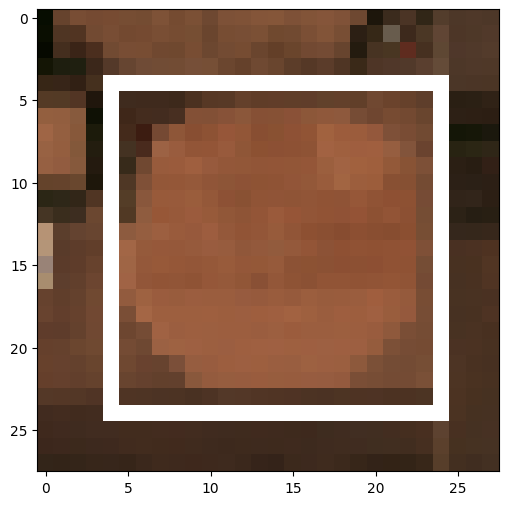

In [17]:
# Calculations

# NDVI
ndvi_ts = utils.generate_ndvi_time_series(images=images)

# NDVI curve smoothing
cleany = ws.whittaker_smooth(np.array(ndvi_ts), lmbd=10, d=2)

In [18]:
# Boxcox Transformation.
fitted_data, fitted_lambda = stats.boxcox(cleany)

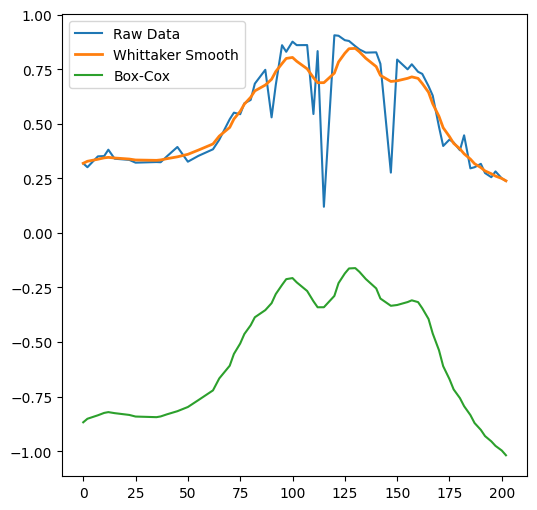

In [21]:
# Plotting 
plt.figure()
plt.plot(days, ndvi_ts, label="Raw Data") 
plt.plot(days, cleany, linewidth=2, label="Whittaker Smooth")
plt.plot(days, fitted_data, label="Box-Cox")
plt.legend()
plt.show()

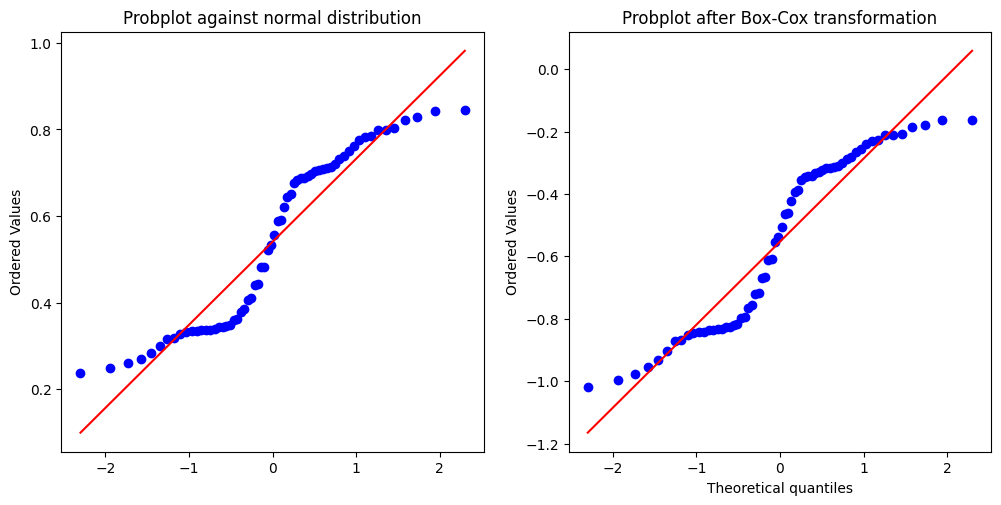

In [20]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(221)
prob = stats.probplot(cleany, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(222)
xt, _ = stats.boxcox(cleany)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')

plt.show()